# Assess whether the model is spun up

In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import matplotlib

%matplotlib inline

#### Parameters:

In [2]:
# domain dimensions:
imin, imax = 1139, 2179
jmin, jmax = 159, 799

isize = imax - imin
jsize = jmax - jmin

# evaluation date
year  = 2002
month = 8

# indices of stations:
stn_n = ['BB1', 'BB2', 'BB3', 'CAA1', 'CAA2', 'CAA3', 'CAA4', 'CAA5', 'CAA6', 'CAA7', 'CAA8', 'CAA9', \
          'CB1', 'CB2', 'CB3', 'CB4']
stn_i = np.array([174, 337, 316, 444, 440, 431, 515, 515, 573, 554, 692, 582, 798, 848, 887, 969])
stn_j = np.array([405, 415, 382, 370, 365, 353, 311, 326, 313, 281, 281, 364, 332, 384, 457, 471])

# folders:
initial_conds = '/ocean/brogalla/GEOTRACES/data/Pb-tuning-202210/Pb-ini-20221103.nc' 

# colors
cmap   = matplotlib.cm.get_cmap('terrain')
colors = [matplotlib.colors.rgb2hex(cmap(i)) for i in np.linspace(0,0.95,len(stn_n))] # in hex format

#### Load files:

In [3]:
mask  = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
tmask = np.array(mask.variables['tmask'])[0,:,imin:imax,jmin:jmax]

e3t        = np.array(mask.variables['e3t_0'])[0,:,imin:imax,jmin:jmax]
e3t_masked = np.ma.masked_where((tmask[:,:,:] < 0.1), e3t)
hdept      = np.array(mask.variables['hdept'])[0,imin:imax,jmin:jmax]

In [4]:
ref   = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12-EXH006_y2015m01d05_gridT.nc',  'r')
depth = np.array(ref.variables['deptht'])

#### Calculations:

In [9]:
def create_file_list(folder):
    
    end_yr0       = [f'{initial_conds}' for month in range(1,13)]
    files_end_yr1 = [f'{folder}-spin0/ANHA12_EXH006_1m_20020101_20021231_comp_2002{month:02}-2002{month:02}.nc' for month in range(1,13)]
    files_end_yr2 = [f'{folder}-spin1/ANHA12_EXH006_1m_20020101_20021231_comp_2002{month:02}-2002{month:02}.nc' for month in range(1,13)]
    files_end_yr3 = [f'{folder}-spin2/ANHA12_EXH006_1m_20020101_20021231_comp_2002{month:02}-2002{month:02}.nc' for month in range(1,13)]

    file_list = end_yr0 + files_end_yr1 + files_end_yr2 + files_end_yr3

    return file_list

In [7]:
def load_file(filename):
    
    pb_file    = nc.Dataset(f'{filename}')
    try:
        pb_monthly = np.array(pb_file.variables['dissolpb'])[0,:,:,:]
    except:
        pb_monthly = np.array(pb_file.variables['dPb'])[0,:,imin:imax,jmin:jmax]
    
    return pb_monthly

In [8]:
def calculate_monthly_difference(file_list):
    pb_monthly = np.zeros((len(file_list),50,isize,jsize))
    difference = np.zeros((len(file_list)-12,len(stn_i)))

    for f, filename in enumerate(file_list):
            pb_monthly[f,:,:,:] = load_file(filename)
            
            # for months after the end of the initial conditions:
            if (f > 11):
                
                # Calculate difference relative to same month in previous year and sum over all indices
                difference[f-12,:] = np.array([np.ma.sum(np.abs(pb_monthly[f,:,i,j] - \
                                                                pb_monthly[f-12,:,i,j])*e3t_masked[:,i,j]) / hdept[i,j] \
                                                            for i, j in zip(stn_i, stn_j)])
       
    return difference

The year-to-year change is calculated as the sum over all depths of the concentration at the observed stations, $stn$, for each month from one year compared to the previous year. 

$$ diff_{stn} = \frac{1}{hdept} \sum^{50}_{z=0} | Pb_{stn}(z,month,yr) - Pb_{stn}(z,month,yr-1) | e3t(z) $$

In [10]:
reference_files = create_file_list('/data/brogalla/run_storage/Pb-tuning-202210/Pb-202211-IC-2002')

In [11]:
difference_reference = calculate_monthly_difference(reference_files)

#### Figures:

In [12]:
def plot_spinup_change(ax, difference, file_list, legend=False):

    months = range(1, len(reference_files)+1-12)
#     years  = np.linspace(2, 1+nruns, (nruns-1)*12 + 1)[0:-1]
    
    for stn, stn_name in enumerate(stn_n):
        ax.plot(months, difference[:,stn]*1e12, '-', c=colors[stn], label=stn_name, linewidth=1.5)
        ax.plot(months, difference[:,stn]*1e12, '.', c=colors[stn], markersize=6, markeredgecolor='k', markeredgewidth=0.5)

    # Line for spread in values
    ax.plot(months, (np.max(difference,axis=1)-np.min(difference,axis=1))*1e12, '--k', linewidth=1.2, label='spread')

#     ax.xaxis.set_ticks(np.linspace(2,2+nruns-1, (nruns-1)*2 + 1))
    ax.tick_params(axis='both', which='major', labelsize=6)
    
    ax.set_ylabel(r'Pb change w.r.t. previous year [pmol L$^{-1}$]', fontsize=7)
    ax.set_xlabel('Months of spin up', fontsize=7);
    if legend:
        font = matplotlib.font_manager.FontProperties(size=7)
        ax.legend(loc=(0.8, 0.5), frameon=False, prop=font, ncol=2)
    
    return

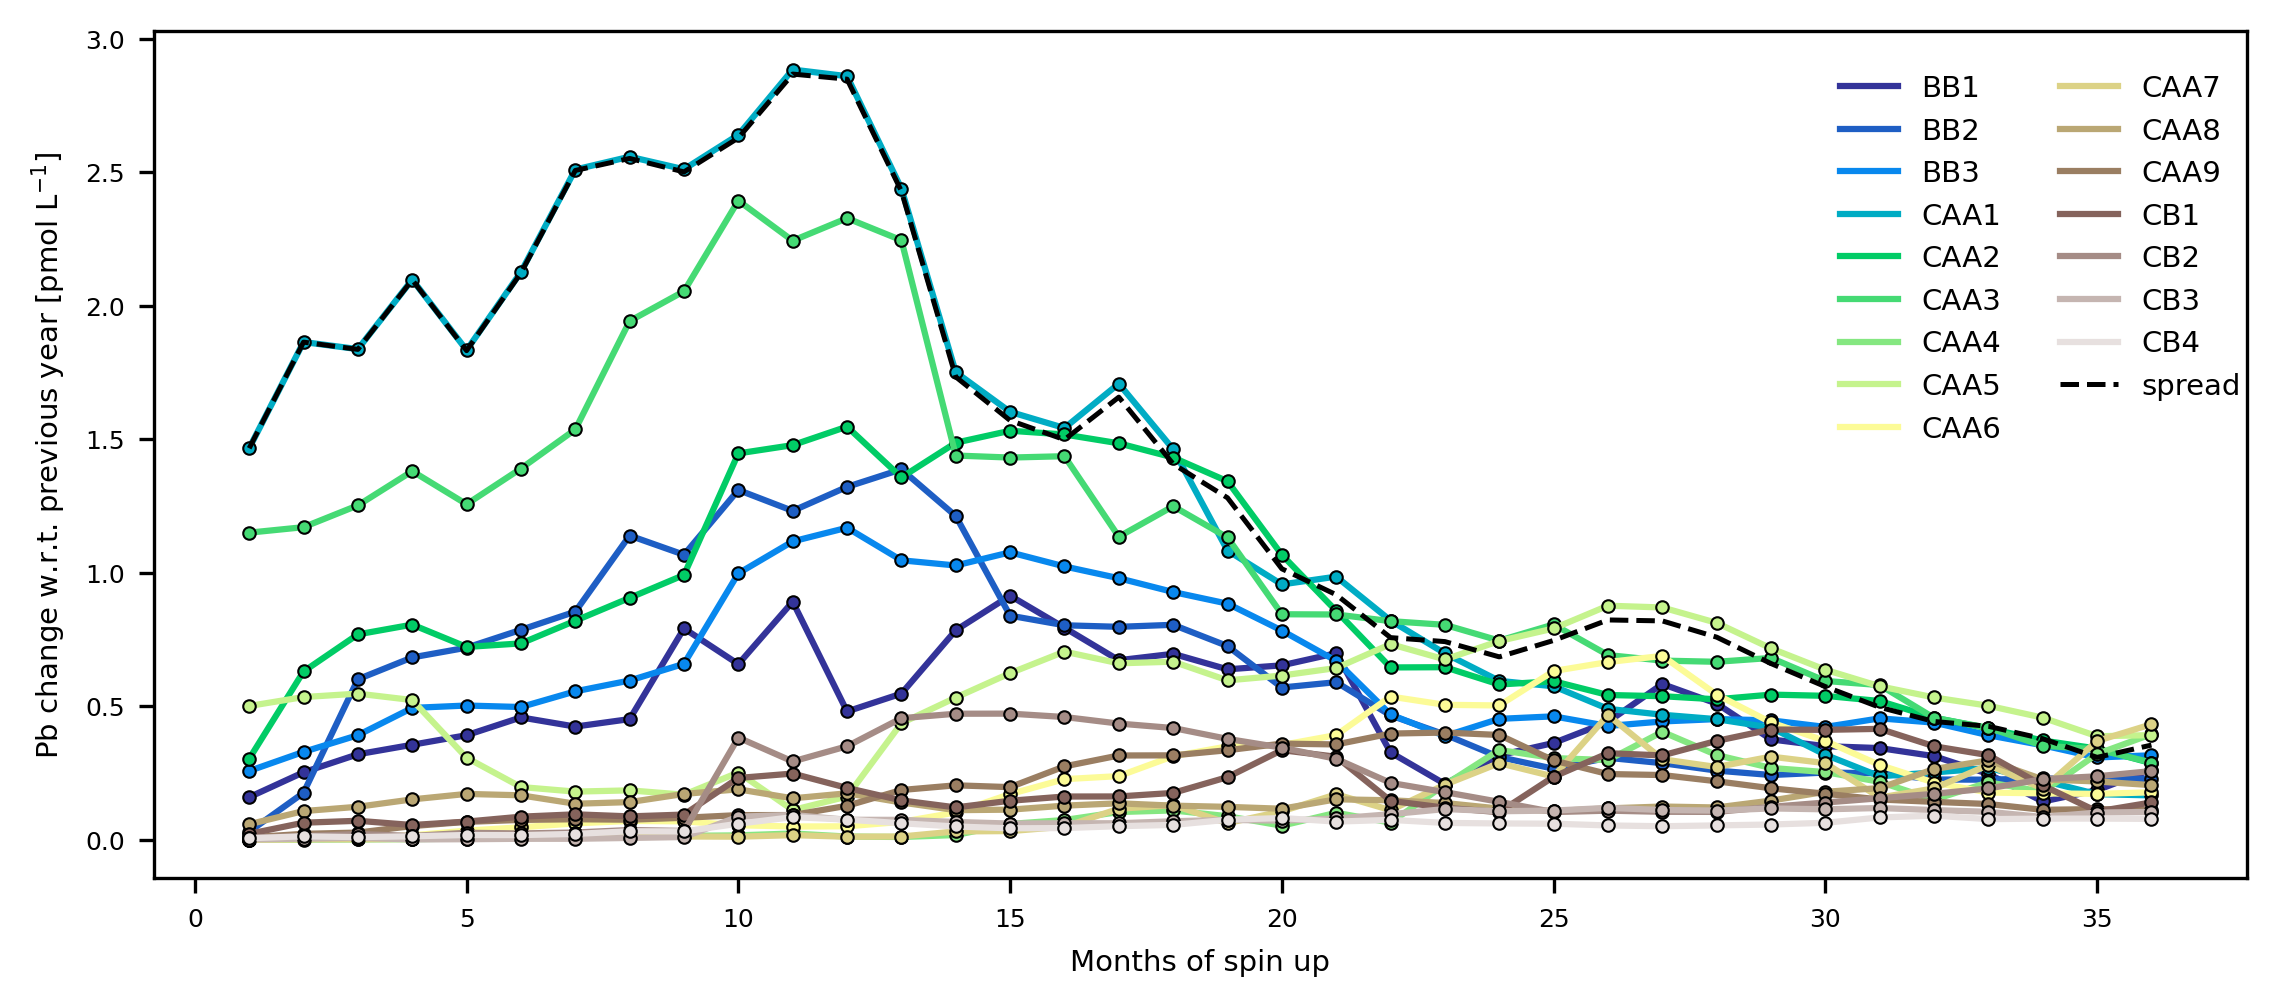

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(4.5*2, 3.74), dpi=300)

plot_spinup_change(ax, difference_reference, reference_files, legend=True)

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202204/S11-spin-up.jpg', bbox_inches='tight', dpi=300)
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202204/S11-spin-up.svg', bbox_inches='tight', dpi=300, \
#                     format='svg')

#### Estimate transit time based on particle tracking

In [3]:
from parcels import FieldSet, ParticleSet, JITParticle, AdvectionRK4, ErrorCode
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits.basemap import Basemap
from datetime import timedelta as delta
import glob
import xarray as xr

INFO: Compiled ParcelsRandom ==> /tmp/parcels-2672/libparcels_random_53310fe4-cf5c-4768-9b3e-f46ac1ae4c25.so


In [4]:
mesh_mask = '/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc'

files_U = list(np.sort(glob.glob('/data/brogalla/ANHA12/ANHA12-EXH006_y200?m??d??_gridU.nc')))
files_V = list(np.sort(glob.glob('/data/brogalla/ANHA12/ANHA12-EXH006_y200?m??d??_gridV.nc')))

filenames = {'U': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': mesh_mask, 'data': files_U},
             'V': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': mesh_mask, 'data': files_V}}

dimensions = {'U': {'lon': 'nav_lon', 'lat': 'nav_lat', 'depth': 'nav_lev', 'time': 'time_counter'},
              'V': {'lon': 'nav_lon', 'lat': 'nav_lat', 'depth': 'nav_lev', 'time': 'time_counter'}}

variables = {'U': 'vozocrtx',
             'V': 'vomecrty'}

fieldset  = FieldSet.from_nemo(filenames, variables, dimensions)

In [5]:
def DeleteParticle(particle, fieldset, time):
    print("Particle [%d] lost !! (%g %g %g %g)" % (particle.id, particle.lon, particle.lat, particle.depth, particle.time))
    particle.delete()

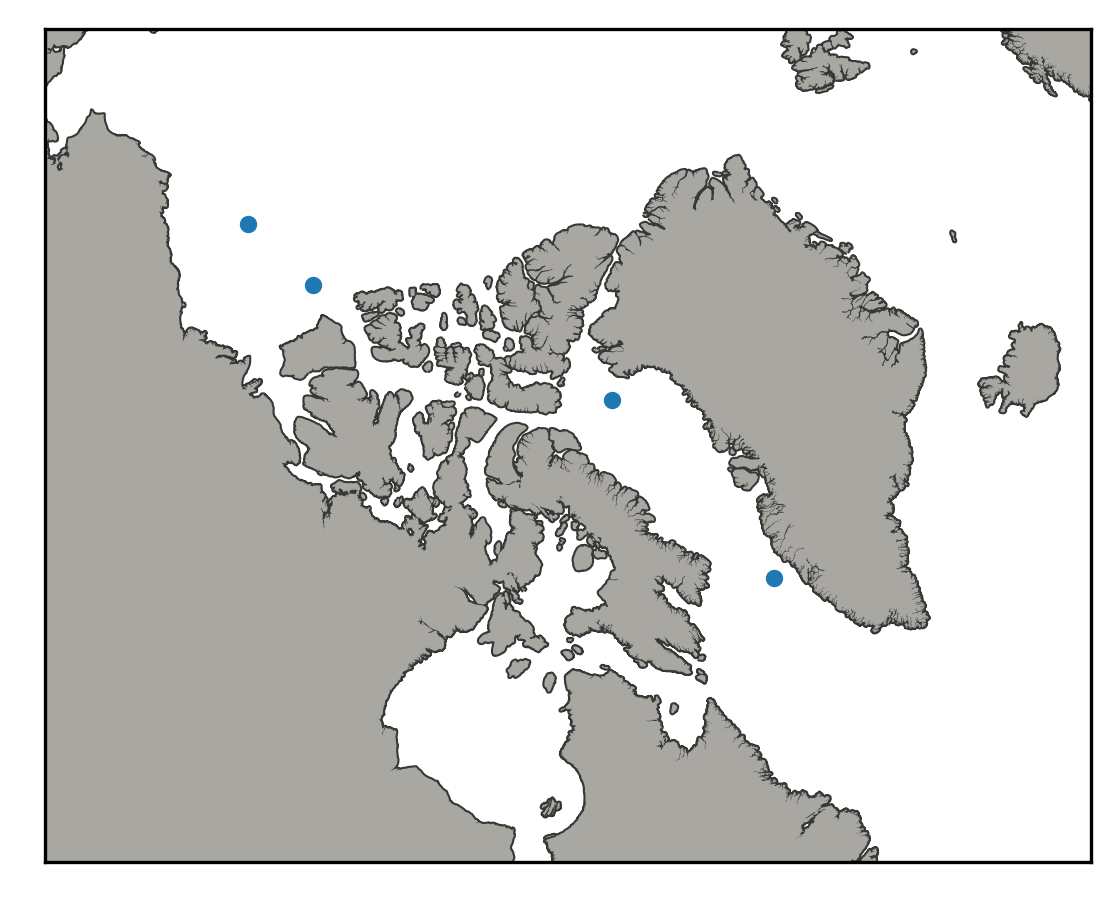

In [6]:
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/pb-surface.pickle','rb'))

x,y = proj1([-130, -145, -70, -55], [75, 74, 75, 65])
ax1.scatter(x, y, s=10)

In [15]:
release_lon   = [-130, -145, -70, -55] # east
release_lat   = [75, 74, 75, 65]  # north
release_depth = [31, 31, 31, 31]      #

pset = ParticleSet.from_list(fieldset = fieldset,       # the fields on which the particles are advected
                             pclass   = JITParticle,    # the type of particles (JITParticle or ScipyParticle)
                             lon      = release_lon,    # a vector of release longitudes 
                             lat      = release_lat,    # a vector of release latitudes
                             depth    = release_depth)   # a vector of release depths) # repeat release of particles

In [16]:
kernels     = pset.Kernel(AdvectionRK4) 
output_file = pset.ParticleFile(name="/ocean/brogalla/GEOTRACES/data/CB_2002-2003_z31.nc", outputdt=delta(hours=24*5))

In [17]:
pset.execute(kernels, runtime=delta(hours=24*365*3), dt=delta(hours=24*5), \
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle}, \
             output_file=output_file)
output_file.export()
# dt      --- the timestep of the kernel
# runtime --- the total length of the run

INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-2672/012743208b060b43a03fdf1a521eed83_0.so
INFO: Temporary output files are stored in /ocean/brogalla/GEOTRACES/data/out-KVZIYEQJ.
INFO: You can use "parcels_convert_npydir_to_netcdf /ocean/brogalla/GEOTRACES/data/out-KVZIYEQJ" to convert these to a NetCDF file during the run.
100% (94608000.0 of 94608000.0) |########| Elapsed Time: 1:00:32 Time:  1:00:32


Look at particle tracks:

In [18]:
def load_tracks(filename):
    file  = xr.open_dataset(filename)
    traj  = file['trajectory'].values # dimensions: number of particles, tracks
    time  = file['time'].values       # units: seconds
    lat   = file['lat'].values        # degrees North
    lon   = file['lon'].values        # degrees East
    depth = file['z'].values        # degrees East

    return traj, time, lon, lat, depth

In [23]:
# CB_2002-2003_1.nc
traj_RK4, time_RK4, lon_RK4, lat_RK4, depth_RK4 = load_tracks('/ocean/brogalla/GEOTRACES/data/CB_2002-2003_z31.nc')

In [24]:
colors_time  = plt.cm.plasma(np.linspace(0,1,traj_RK4.shape[0]))

In [25]:
time_RK4[0,-1]

numpy.timedelta64(94608000000000000,'ns')

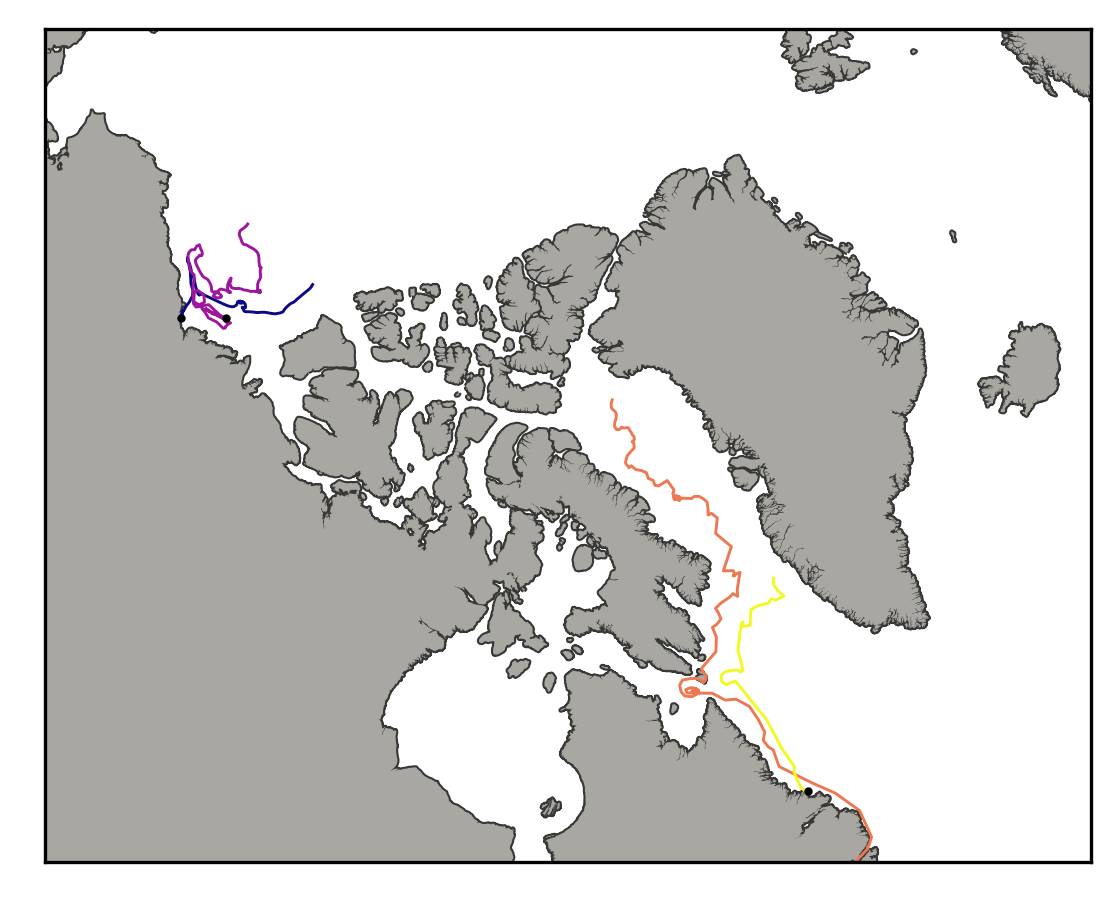

In [26]:
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/pb-surface.pickle','rb'))

x,y = proj1(lon_RK4, lat_RK4)

for particle in range(0,traj_RK4.shape[0]):
    x_plot = x[particle,:][x[particle,:] < 1e10]
    y_plot = y[particle,:][y[particle,:] < 1e10]
    
    ax1.plot(x_plot, y_plot,'-', linewidth=0.7, color=colors_time[particle])
    ax1.plot(x_plot[-1], y_plot[-1],'.w', markersize=2, markeredgecolor='k')
#     c = ax1.scatter([0,0],[0,0], s=0.3, c=[0,40], cmap='plasma_r', vmin=0, vmax=40) # just for colorbar
        
# fig.colorbar(c, shrink=0.5, label='Time [hours]')